In [20]:
import os
import S4
import numpy as np
import scipy.constants as consts
import matplotlib.pyplot as plt
%matplotlib notebook

# Introduction

This is a test of S4, comparing it to analytical solutions taken from Griffiths Introduction to Electrodynamics Chapter 9 Section 3.2. 

In this test, we have an infinite half-space of vacuum above an infinite half-space of an arbitrary lossless material. The interface between the
two materials sits at $z=0$, and the phase of the incident plane wave is measured relative to $z = 0$.

First we set up the simulation cell. Note that in the Lorentz-Heaviside unit system used by S4, all lengths are specified as multiples of some common
reference length unit. So, the ones specified below won't really take on any meaning unit we start sending in light at some physical frequency and need
to convert that frequency into LH units.

In [21]:
L = 1
numbasis = 10
sim = S4.New(Lattice=((L, 0), (0, L)), NumBasis=numbasis)

Next we set up a material. I'm choosing a material with a purely real value for the relative permitivity. This means there should be no absorption and the electric
field amplitude should stay constant, but its frequency should be modified. Recall that

\begin{align}
    \mathrm{Re}(\epsilon_r) &= n^2 - k^2 \\
    \mathrm{Im}(\epsilon_r) &= 2nk 
\end{align}                  

where $n$ and $k$ are the real and imaginary parts of the index of refraction. Setting $Re(\epsilon) = 4$ means $n = 2$.

In [22]:
eps_real_vac = 1
eps_real_slab = 4
n_slab = np.sqrt(eps_real_slab)
sim.SetMaterial(Name = "TestMaterial", Epsilon = eps_real_slab)
sim.SetMaterial(Name = "Vacuum", Epsilon = eps_real_vac)

Now we just make the layer structure

In [23]:
sim.AddLayer(Name='VacuumAbove', Thickness = 0, Material='Vacuum')
sim.AddLayer(Name='Slab', Thickness = 0, Material='TestMaterial')

Now we need to set up the incident plane wave. This is where the unit system in S4 gets a little annoying. In LH
units $c = \mu_0 = \epsilon_0 = 1$. To convert from a physical, SI frequency into an LH frequency you need to employ
the following prescription

\begin{equation}
    f_{LH} = \frac{f_{SI}}{c}
\end{equation}
   
Where the speed of light $c$ is expressed in your reference length unit of choice. For example, if we decide that our reference
length unit is a micro meter (meaning our unit cell side length $L = 1 \mathrm{ \mu m}$) then  $c = 2.998 x 10^{14} \mathrm{ \mu m/s}$.
This is the  value of $c$ that needs to be used to convert SI frequencies to LH frequencies. Note also that S4 does not want angular
frequencies, it wants the frequency in cycles/second (i.e Hertz)

So first lets specify the frequency

In [24]:
SI_freq = 2e14 # Hertz
SI_wvlgth = 1e6*consts.c / SI_freq
print(SI_wvlgth)
LH_freq = SI_freq/(consts.c * 1e6) 
print(LH_freq)
sim.SetFrequency(LH_freq)

1.49896229
0.6671281903963041


Now we can actually specify the excitation. For normally incident waves, S4 uses the convention that the p polarization is along the x direction.
So, below we set up an incident wave that is normally incident and linearly polarized along the x axis. The amplitudes specified below are for
the electric field, and we just choose an amplitude of 1 for simplicity. The angles below must be specified in degrees if you want to change 
them

In [40]:
polar_angle = 0
azimuth_angle = 0
incident_amp = complex(2.5, 0)
sim.SetExcitationPlanewave(IncidenceAngles=(np.rad2deg(polar_angle), azimuth_angle), sAmplitude=complex(0, 0), pAmplitude=incident_amp)

That's it! Now we should be ready to compute the fields along the z-direction at an arbitrary x-y point

<IPython.core.display.Javascript object>


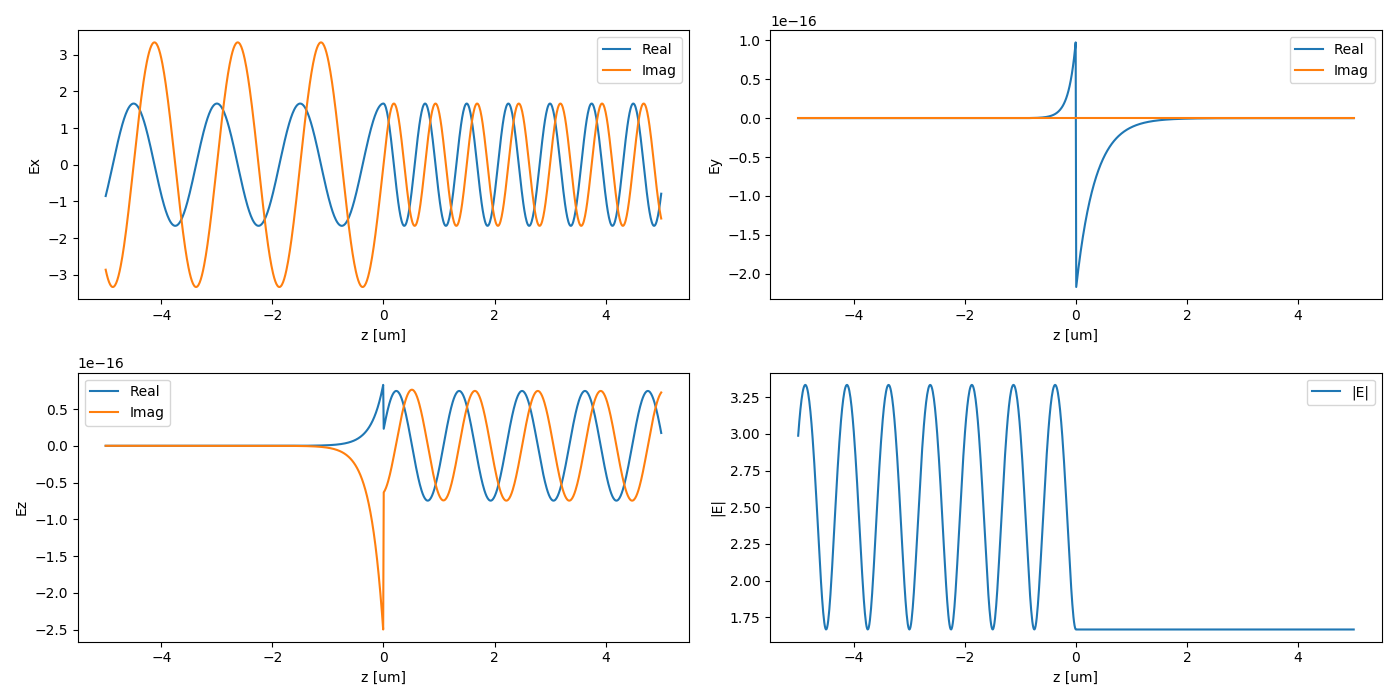

In [41]:
z_vals = np.linspace(-5, 5, 1000)
Ex = np.zeros_like(z_vals, dtype=np.complex)
Ey = np.zeros_like(z_vals, dtype=np.complex)
Ez = np.zeros_like(z_vals, dtype=np.complex)
for i, z in enumerate(z_vals):
    E, H = sim.GetFields(0, 0, z)
    Ex[i] = E[0]
    Ey[i] = E[1]
    Ez[i] = E[2]
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.plot(z_vals, Ex.real, label = "Real")
ax1.plot(z_vals, Ex.imag, label = "Imag")
ax1.set_ylabel('Ex')
ax1.set_xlabel('z [um]')
ax1.legend()
ax2.plot(z_vals, Ey.real, label = "Real")
ax2.plot(z_vals, Ey.imag, label = "Imag")
ax2.set_ylabel('Ey')
ax2.set_xlabel('z [um]')
ax2.legend()
ax3.plot(z_vals, Ez.real, label = "Real")
ax3.plot(z_vals, Ez.imag, label = "Imag")
ax3.set_ylabel('Ez')
ax3.set_xlabel('z [um]')
ax3.legend()
normE = np.sqrt(np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2)
ax4.plot(z_vals, normE, label = "|E|")
ax4.legend()
ax4.set_ylabel('|E|')
ax4.set_xlabel('z [um]')
plt.tight_layout()
plt.show()

Next step is to set up the analytic equations. These results are just straight up copied from Griffiths, for
arbitary angle of incidence.

First, the velocity of the wave in the slab must be

\begin{equation}
    v_{slab} = \frac{c}{n_{slab}}
\end{equation}

Snell's law tells use the relationship between the incident angle and the transmitted angle

\begin{equation}
    \frac{\sin(\theta_T)}{\sin(\theta_I)} = \frac{n_1}{n_2}
\end{equation}

Griffiths then defines some constants

\begin{align}
    \alpha &= \frac{\cos(\theta_T)}{\cos(\theta_I)} \\
    \beta &= \frac{\mu_1 n_2}{\mu_2 n_1}
\end{align}

In our case $\mu_1 = \mu_2 = \mu_0$ for simplicity (the slab is non magnetic)

Now we can compute the amplitudes of the reflected and transmitted waves analytically in terms of the incident amplitude

\begin{align}
    E_{0, R} &= \frac{\alpha - \beta}{\alpha + \beta} E_{0, I} \\ 
    E_{0, T} &= \frac{2}{\alpha + \beta} E_{0, I} \\ 
\end{align}

I write a function to compute and return the analytic waves given the necessary parameters below.

In [42]:
def analytic_waves(SI_freq, n_slab, Einc, z_vals, polar_angle):
    # polar_angle must be in radians!!
    # Define constants and scalar magnitudes of vectors
    si_omega = 2*np.pi*SI_freq
    theta_T = np.arcsin((1/n_slab)*np.sin(polar_angle))
    beta = n_slab
    alpha = np.cos(theta_T)/np.cos(polar_angle)
    v_slab = 1e6*consts.c / n_slab
    ktrans = si_omega / v_slab
    kinc = si_omega / (1e6*consts.c)
    kref = kinc
    Eref = Einc*(alpha - beta)/(alpha + beta)
    Etrans = Einc*2/(alpha + beta)
    # Define vector amplitudes and wave vectors
    vEinc = Einc*np.array([np.cos(polar_angle), 0, np.sin(polar_angle)])
    vkinc = kinc*np.array([np.sin(polar_angle), 0, np.cos(polar_angle)])
    vEtrans = Etrans*np.array([np.cos(theta_T), 0, np.sin(theta_T)])
    vktrans = ktrans*np.array([np.sin(theta_T), 0, np.cos(theta_T)])
    vEref = Eref*np.array([np.cos(polar_angle), 0, np.sin(polar_angle)])
    vkref = kref*np.array([np.sin(polar_angle), 0, np.cos(polar_angle)])
    # Define 3D positions
    r_vals = np.zeros((z_vals.shape[0], 3))
    r_vals[:, 2] = z_vals
    # Get phases
    inc_phase = np.exp(1j*np.dot(r_vals, vkinc))
    ref_phase = np.exp(-1j*np.dot(r_vals, vkref))
    trans_phase = np.exp(1j*np.dot(r_vals, vktrans))
    inc_wave = vEinc*np.column_stack((inc_phase, inc_phase, inc_phase))
    ref_wave = vEref*np.column_stack((ref_phase, ref_phase, ref_phase))
    trans_wave = vEtrans*np.column_stack((trans_phase, trans_phase, trans_phase))
    air_wave = inc_wave + ref_wave
    ind_arr = np.where(z_vals < 0)
    total_wave = np.zeros_like(inc_wave)
    total_wave[ind_arr, :] = air_wave[ind_arr, :]
    ind_arr = np.where(z_vals >= 0)
    total_wave[ind_arr, :] =trans_wave[ind_arr, :]
    Ex = total_wave[:,0]
    Ey = total_wave[:,1]
    Ez = total_wave[:,2]
    return Ex, Ey, Ez 

In [43]:
aEx, aEy, aEz = analytic_waves(SI_freq, n_slab, incident_amp, z_vals, polar_angle)

<IPython.core.display.Javascript object>


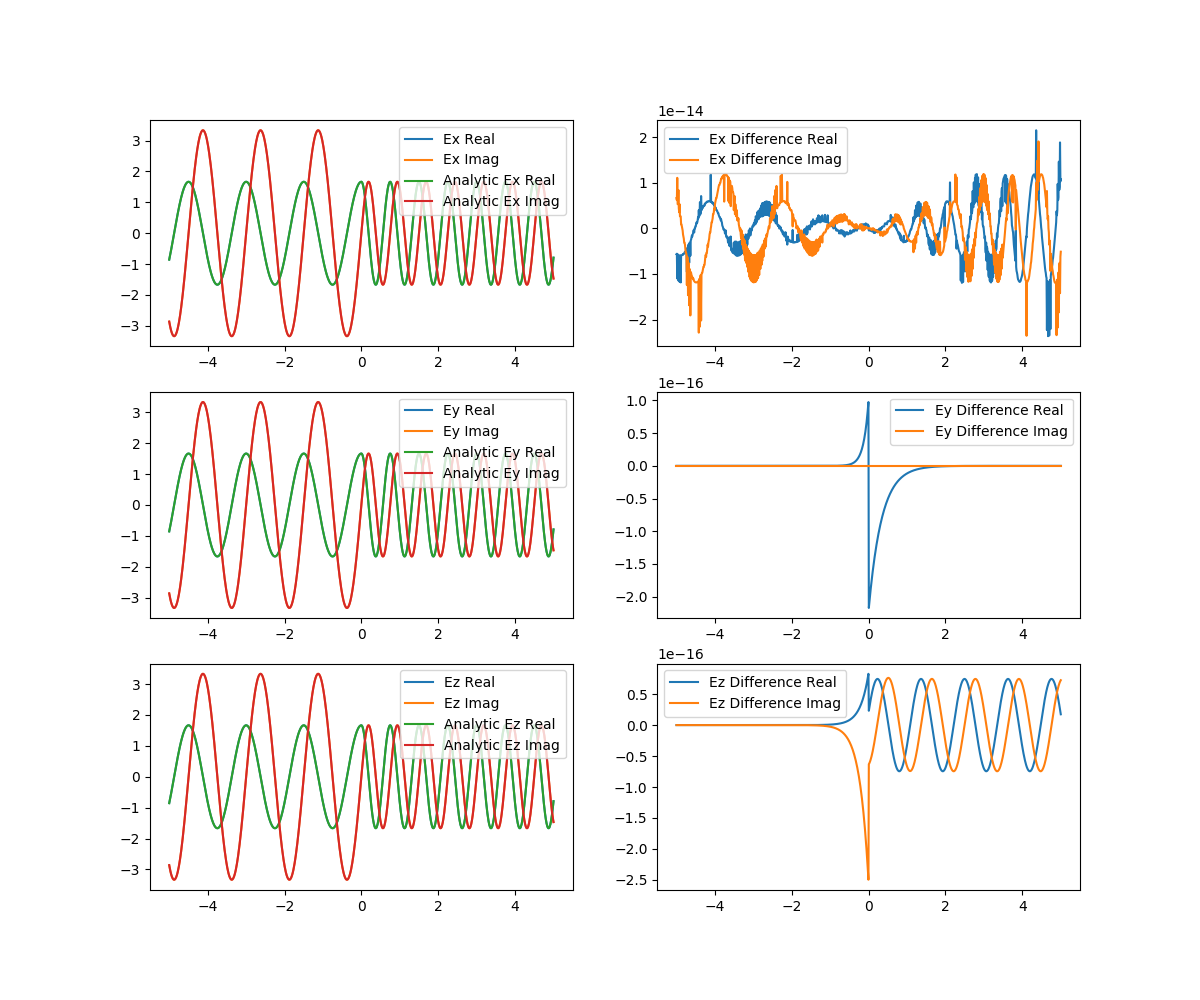

In [47]:
diff = aEx - Ex
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, comp in enumerate([(Ex, aEx, 'Ex'), (Ey, aEy, 'Ey'), (Ez, aEz, 'Ez')]):
    numeric_result = comp[0]
    analytic_result = comp[1]
    lab = comp[2]
    diff = numeric_result - analytic_result
    axes[i, 0].plot(z_vals, Ex.real, label="%s Real"%lab)
    axes[i, 0].plot(z_vals, Ex.imag, label="%s Imag"%lab)
    axes[i, 0].plot(z_vals, aEx.real, label="Analytic %s Real"%lab)
    axes[i, 0].plot(z_vals, aEx.imag, label="Analytic %s Imag"%lab)
    axes[i, 0].legend()
    axes[i, 1].plot(z_vals, diff.real, label="%s Difference Real"%lab)
    axes[i, 1].plot(z_vals, diff.imag, label="%s Difference Imag"%lab)
    axes[i, 1].legend()
plt.show()